
### Predicting Burnt Area During Forest Fires
##### This notebook analyzes and predicts the burnt area during the forest fire incidents based on meteorological and other related conditions during forest fire incidents in Portugal between 2009 and 2018.
    

In [5]:

%pip install pandas kagglehub matplotlib seaborn scikit-learn numpy

import os
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

Note: you may need to restart the kernel to use updated packages.



### Download Dataset
##### Downloads the latest version of the dataset using KaggleHub.
    

In [6]:

dataset_path = kagglehub.dataset_download("sumitm004/forest-fire-area")
print(f"Dataset downloaded to: {dataset_path}")

Dataset downloaded to: C:\Users\anish\.cache\kagglehub\datasets\sumitm004\forest-fire-area\versions\6



### Load and Preprocess Dataset
#####  The dataset is imported and stored in a structured format. Categorical variables, such as months and days, are converted into numerical representations so they can be effectively used in modeling. One category from each transformed column is intentionally left out to prevent unnecessary duplication of information, which could otherwise lead to issues in the learning process.
    

In [7]:

df = pd.read_csv(os.path.join(dataset_path, "forestfires.csv"))
df = pd.get_dummies(df, columns=['month', 'day'], drop_first=True)
df.head()


,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_may,month_nov,month_oct,month_sep,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,False,False,False,False,False,False,False,False,False,False
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,False,False,True,False,False,False,False,False,True,False
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,False,False,True,False,False,True,False,False,False,False
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,False,False,False,False,False,False,False,False,False,False
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,False,False,False,False,False,False,True,False,False,False



### Standardizing Numerical Features
##### The numerical variables in the dataset are adjusted to have a consistent scale, improving model performance and ensuring fair comparisons between features. This transformation centers the values around zero and adjusts them to have a standard range, preventing certain features from dominating due to larger numerical values. The selected features include spatial coordinates, meteorological factors, and fire-related indices.

In [8]:

scaler = StandardScaler()
numerical_features = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
df[numerical_features] = scaler.fit_transform(df[numerical_features])
df.head()


,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_may,month_nov,month_oct,month_sep,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,1.008313,0.569860,-0.805959,-1.323326,-1.830477,-0.860946,-1.842640,0.411724,1.498614,-0.073268,...,False,False,False,False,False,False,False,False,False,False
1,1.008313,-0.244001,-0.008102,-1.179541,0.488891,-0.509688,-0.153278,-0.692456,-1.741756,-0.073268,...,False,False,True,False,False,False,False,False,True,False
2,1.008313,-0.244001,-0.008102,-1.049822,0.560715,-0.509688,-0.739383,-0.692456,-1.518282,-0.073268,...,False,False,True,False,False,True,False,False,False,False
3,1.440925,1.383722,0.191362,-1.212361,-1.898266,-0.004756,-1.825402,3.233519,-0.009834,0.603155,...,False,False,False,False,False,False,False,False,False,False
4,1.440925,1.383722,-0.243833,-0.931043,-1.798600,0.126966,-1.291012,3.356206,-1.238940,-0.073268,...,False,False,False,False,False,False,True,False,False,False


## Feature Engineering
### New variables are made to enhance the model's ability to capture important patterns. The burnt area is transformed using a logarithmic scale to reduce the impact of extreme values and improve prediction stability. Additionally, a new variable representing fire potential is created by combining temperature and wind speed, as higher values of both can contribute to fire spread. 
    

In [9]:

df['log_area'] = np.log1p(df['area'])
df['fire_potential'] = df['temp'] * df['wind']
df.head()


,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_oct,month_sep,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed,log_area,fire_potential
0,1.008313,0.569860,-0.805959,-1.323326,-1.830477,-0.860946,-1.842640,0.411724,1.498614,-0.073268,...,False,False,False,False,False,False,False,False,0.0,-2.761407
1,1.008313,-0.244001,-0.008102,-1.179541,0.488891,-0.509688,-0.153278,-0.692456,-1.741756,-0.073268,...,True,False,False,False,False,False,True,False,0.0,0.266973
2,1.008313,-0.244001,-0.008102,-1.049822,0.560715,-0.509688,-0.739383,-0.692456,-1.518282,-0.073268,...,True,False,False,True,False,False,False,False,0.0,1.122592
3,1.440925,1.383722,0.191362,-1.212361,-1.898266,-0.004756,-1.825402,3.233519,-0.009834,0.603155,...,False,False,False,False,False,False,False,False,0.0,0.017950
4,1.440925,1.383722,-0.243833,-0.931043,-1.798600,0.126966,-1.291012,3.356206,-1.238940,-0.073268,...,False,False,False,False,True,False,False,False,0.0,1.599486


## Exploratory Data Analysis
##### The first visualization is a heatmap of feature correlations, highlighting the relationships between different variables in the dataset. This helps identify any strong correlations that may exist, assisting in feature selection and understanding the underlying patterns. The heatmap's color gradient (from cool to warm) visually emphasizes these relationships and display correlation values for easy interpretation.

##### The second visualization focuses on the distribution of the burnt area. A histogram is used to show the frequency of different burnt area values, helping to understand the spread of this target variable. The x-axis is limited to the 99th percentile of the burnt area to avoid extreme outliers that could distort the visualization.
    

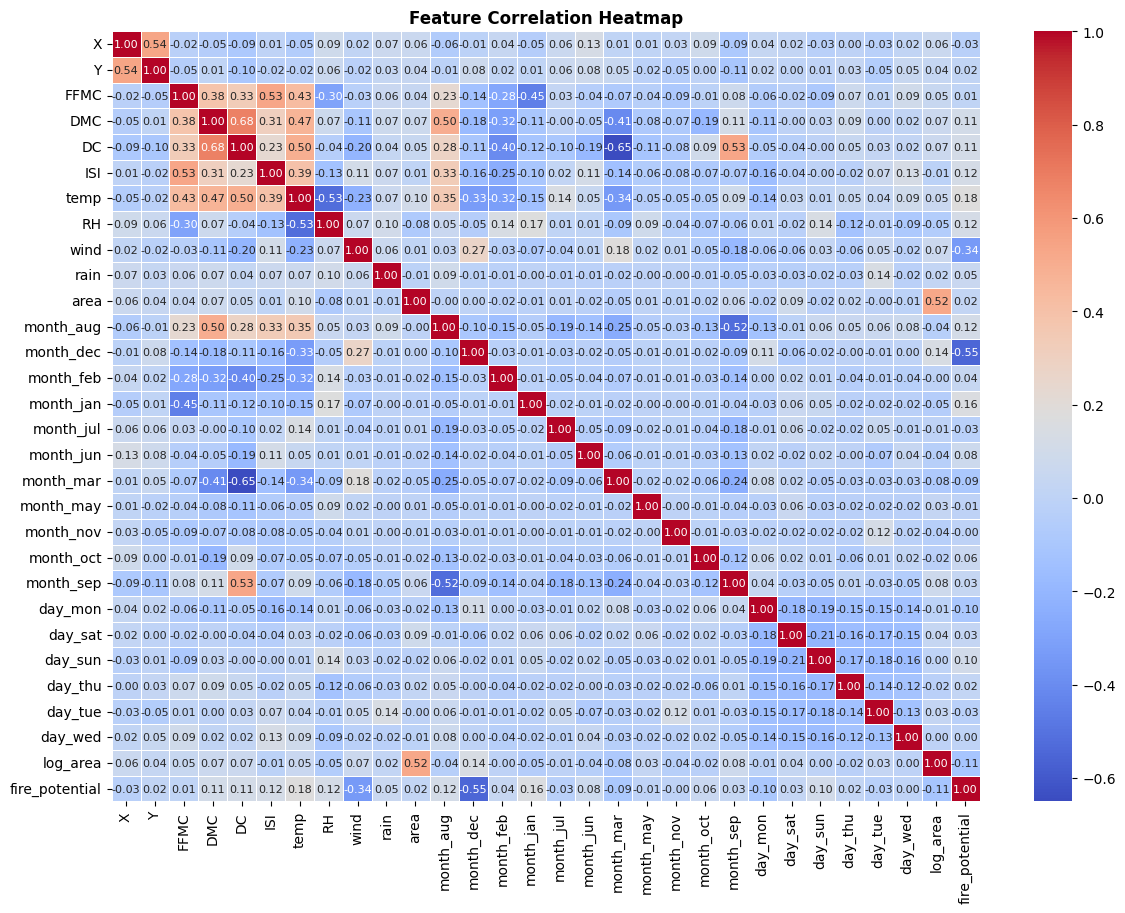

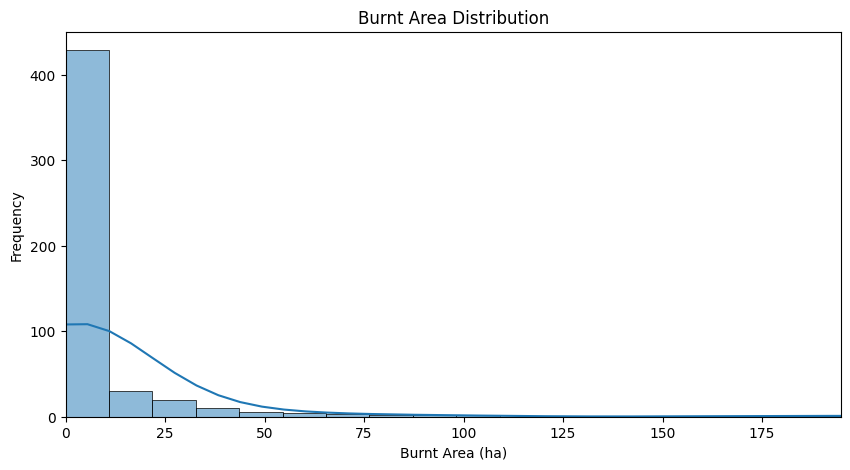

In [10]:

plt.figure(figsize=(14, 10))  # Increase figure size
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8}, linewidths=0.5)
plt.yticks(fontsize=10)  # Reduce y-axis label size
plt.title("Feature Correlation Heatmap", fontsize=12, fontweight='bold')
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df['area'], bins=100, kde=True)
plt.title("Burnt Area Distribution")
plt.xlabel("Burnt Area (ha)")
plt.ylabel("Frequency")
plt.xlim(0, df['area'].quantile(0.99))
plt.show()


### Model Training
##### The data is split into training and testing sets, where the features are separated from the burnt area. The training set is used to build the model, and the testing set is reserved for evaluating its performance. A Random Forest model is trained using a hyperparameter tuning process, where multiple configurations of the model (e.g., number of trees, tree depth, minimum samples for splitting/leafing) are tested through grid search. Once the best model is determined, predictions are made on the testing set. The model’s performance is then evaluated using several metrics: Mean Absolute Error (MAE), Mean Squared Error (MSE), and R² score, which collectively help assess the model's accuracy.
    

In [ ]:

features = df.drop(columns=['area', 'log_area'])
target = df['log_area']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, scoring='r2')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")

feature_importances = pd.DataFrame({'Feature': features.columns, 'Importance': best_model.feature_importances_})
print("Top Features:")
print(feature_importances.sort_values(by='Importance', ascending=False).head(10))
